In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
import torch
model = torch.hub.load('pytorch/vision:v0.9.0', 'densenet201', pretrained=True)
model.eval()

Using cache found in C:\Users\Otakuking/.cache\torch\hub\pytorch_vision_v0.9.0


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [3]:
batch_size = 16
learning_rate = 0.001

transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='emotion4ver/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion4ver/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([16, 3, 224, 224])
out-size: torch.Size([3, 454, 1810])


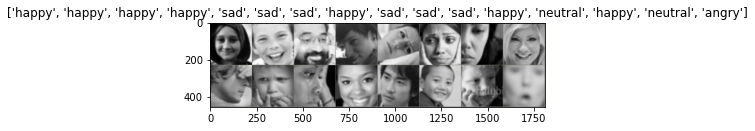

In [5]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [6]:
net = model
net = net.cuda() if device else net
net

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.00001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=False)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [8]:
n_epochs = 30
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'Densenet201_lr0.001_adam_batch16_epoch30.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/30], Step [0/1313], Loss: 11.5698
Epoch [1/30], Step [20/1313], Loss: 1.5057
Epoch [1/30], Step [40/1313], Loss: 1.5031
Epoch [1/30], Step [60/1313], Loss: 1.3237
Epoch [1/30], Step [80/1313], Loss: 1.5377
Epoch [1/30], Step [100/1313], Loss: 1.2451
Epoch [1/30], Step [120/1313], Loss: 0.6014
Epoch [1/30], Step [140/1313], Loss: 1.4094
Epoch [1/30], Step [160/1313], Loss: 1.1913
Epoch [1/30], Step [180/1313], Loss: 0.7679
Epoch [1/30], Step [200/1313], Loss: 0.7079
Epoch [1/30], Step [220/1313], Loss: 0.8672
Epoch [1/30], Step [240/1313], Loss: 0.9159
Epoch [1/30], Step [260/1313], Loss: 0.6788
Epoch [1/30], Step [280/1313], Loss: 1.1015
Epoch [1/30], Step [300/1313], Loss: 1.1290
Epoch [1/30], Step [320/1313], Loss: 0.8182
Epoch [1/30], Step [340/1313], Loss: 0.9281
Epoch [1/30], Step [360/1313], Loss: 1.0236
Epoch [1/30], Step [380/1313], Loss: 0.6157
Epoch [1/30], Step [400/1313], Loss: 0.7719
Epoch [1/30], Step [420/1313], Loss: 0.6625
Epoch [1/30], Step [440/1313

Epoch [3/30], Step [980/1313], Loss: 0.3499
Epoch [3/30], Step [1000/1313], Loss: 0.4800
Epoch [3/30], Step [1020/1313], Loss: 0.6457
Epoch [3/30], Step [1040/1313], Loss: 0.4785
Epoch [3/30], Step [1060/1313], Loss: 0.4528
Epoch [3/30], Step [1080/1313], Loss: 0.7905
Epoch [3/30], Step [1100/1313], Loss: 1.2775
Epoch [3/30], Step [1120/1313], Loss: 0.6201
Epoch [3/30], Step [1140/1313], Loss: 0.5972
Epoch [3/30], Step [1160/1313], Loss: 0.9189
Epoch [3/30], Step [1180/1313], Loss: 0.7311
Epoch [3/30], Step [1200/1313], Loss: 0.6565
Epoch [3/30], Step [1220/1313], Loss: 0.8014
Epoch [3/30], Step [1240/1313], Loss: 0.5335
Epoch [3/30], Step [1260/1313], Loss: 0.9755
Epoch [3/30], Step [1280/1313], Loss: 0.6622
Epoch [3/30], Step [1300/1313], Loss: 0.5988

train-loss: 1.0229, train-acc: 74.8250
validation loss: 0.7628, validation acc: 70.1458

Improvement-Detected, save-model
Epoch 4

Epoch [4/30], Step [0/1313], Loss: 0.4574
Epoch [4/30], Step [20/1313], Loss: 0.4235
Epoch [4/30], Step 

Epoch [6/30], Step [600/1313], Loss: 0.1252
Epoch [6/30], Step [620/1313], Loss: 0.0694
Epoch [6/30], Step [640/1313], Loss: 0.2923
Epoch [6/30], Step [660/1313], Loss: 0.2243
Epoch [6/30], Step [680/1313], Loss: 0.1267
Epoch [6/30], Step [700/1313], Loss: 0.0634
Epoch [6/30], Step [720/1313], Loss: 0.0912
Epoch [6/30], Step [740/1313], Loss: 0.0771
Epoch [6/30], Step [760/1313], Loss: 0.1897
Epoch [6/30], Step [780/1313], Loss: 0.2356
Epoch [6/30], Step [800/1313], Loss: 0.2075
Epoch [6/30], Step [820/1313], Loss: 0.1849
Epoch [6/30], Step [840/1313], Loss: 0.2384
Epoch [6/30], Step [860/1313], Loss: 0.2077
Epoch [6/30], Step [880/1313], Loss: 0.2867
Epoch [6/30], Step [900/1313], Loss: 0.2231
Epoch [6/30], Step [920/1313], Loss: 0.0804
Epoch [6/30], Step [940/1313], Loss: 0.0943
Epoch [6/30], Step [960/1313], Loss: 0.2242
Epoch [6/30], Step [980/1313], Loss: 0.0573
Epoch [6/30], Step [1000/1313], Loss: 0.2944
Epoch [6/30], Step [1020/1313], Loss: 0.3181
Epoch [6/30], Step [1040/1313]

Epoch [9/30], Step [220/1313], Loss: 0.0886
Epoch [9/30], Step [240/1313], Loss: 0.0173
Epoch [9/30], Step [260/1313], Loss: 0.1908
Epoch [9/30], Step [280/1313], Loss: 0.0170
Epoch [9/30], Step [300/1313], Loss: 0.0097
Epoch [9/30], Step [320/1313], Loss: 0.0138
Epoch [9/30], Step [340/1313], Loss: 0.0122
Epoch [9/30], Step [360/1313], Loss: 0.0131
Epoch [9/30], Step [380/1313], Loss: 0.0101
Epoch [9/30], Step [400/1313], Loss: 0.0260
Epoch [9/30], Step [420/1313], Loss: 0.0629
Epoch [9/30], Step [440/1313], Loss: 0.0200
Epoch [9/30], Step [460/1313], Loss: 0.1316
Epoch [9/30], Step [480/1313], Loss: 0.0403
Epoch [9/30], Step [500/1313], Loss: 0.0735
Epoch [9/30], Step [520/1313], Loss: 0.0130
Epoch [9/30], Step [540/1313], Loss: 0.0032
Epoch [9/30], Step [560/1313], Loss: 0.1147
Epoch [9/30], Step [580/1313], Loss: 0.0227
Epoch [9/30], Step [600/1313], Loss: 0.0205
Epoch [9/30], Step [620/1313], Loss: 0.0125
Epoch [9/30], Step [640/1313], Loss: 0.0866
Epoch [9/30], Step [660/1313], L

Epoch [11/30], Step [1160/1313], Loss: 0.1364
Epoch [11/30], Step [1180/1313], Loss: 0.0624
Epoch [11/30], Step [1200/1313], Loss: 0.0095
Epoch [11/30], Step [1220/1313], Loss: 0.2353
Epoch [11/30], Step [1240/1313], Loss: 0.3425
Epoch [11/30], Step [1260/1313], Loss: 0.0130
Epoch [11/30], Step [1280/1313], Loss: 0.0186
Epoch [11/30], Step [1300/1313], Loss: 0.0062

train-loss: 0.4045, train-acc: 98.6813
validation loss: 0.8948, validation acc: 71.1243

Epoch 12

Epoch [12/30], Step [0/1313], Loss: 0.0246
Epoch [12/30], Step [20/1313], Loss: 0.0152
Epoch [12/30], Step [40/1313], Loss: 0.0212
Epoch [12/30], Step [60/1313], Loss: 0.1037
Epoch [12/30], Step [80/1313], Loss: 0.0153
Epoch [12/30], Step [100/1313], Loss: 0.0525
Epoch [12/30], Step [120/1313], Loss: 0.0662
Epoch [12/30], Step [140/1313], Loss: 0.0273
Epoch [12/30], Step [160/1313], Loss: 0.2045
Epoch [12/30], Step [180/1313], Loss: 0.0033
Epoch [12/30], Step [200/1313], Loss: 0.0100
Epoch [12/30], Step [220/1313], Loss: 0.030

Epoch [14/30], Step [700/1313], Loss: 0.0142
Epoch [14/30], Step [720/1313], Loss: 0.0183
Epoch [14/30], Step [740/1313], Loss: 0.1366
Epoch [14/30], Step [760/1313], Loss: 0.0112
Epoch [14/30], Step [780/1313], Loss: 0.0255
Epoch [14/30], Step [800/1313], Loss: 0.0374
Epoch [14/30], Step [820/1313], Loss: 0.0484
Epoch [14/30], Step [840/1313], Loss: 0.0356
Epoch [14/30], Step [860/1313], Loss: 0.0174
Epoch [14/30], Step [880/1313], Loss: 0.1872
Epoch [14/30], Step [900/1313], Loss: 0.0047
Epoch [14/30], Step [920/1313], Loss: 0.0131
Epoch [14/30], Step [940/1313], Loss: 0.0141
Epoch [14/30], Step [960/1313], Loss: 0.0035
Epoch [14/30], Step [980/1313], Loss: 0.2791
Epoch [14/30], Step [1000/1313], Loss: 0.0067
Epoch [14/30], Step [1020/1313], Loss: 0.0532
Epoch [14/30], Step [1040/1313], Loss: 0.0058
Epoch [14/30], Step [1060/1313], Loss: 0.0075
Epoch [14/30], Step [1080/1313], Loss: 0.3205
Epoch [14/30], Step [1100/1313], Loss: 0.0240
Epoch [14/30], Step [1120/1313], Loss: 0.0031
Epo

Epoch [17/30], Step [240/1313], Loss: 0.0098
Epoch [17/30], Step [260/1313], Loss: 0.0028
Epoch [17/30], Step [280/1313], Loss: 0.1120
Epoch [17/30], Step [300/1313], Loss: 0.0041
Epoch [17/30], Step [320/1313], Loss: 0.0061
Epoch [17/30], Step [340/1313], Loss: 0.0476
Epoch [17/30], Step [360/1313], Loss: 0.1409
Epoch [17/30], Step [380/1313], Loss: 0.0585
Epoch [17/30], Step [400/1313], Loss: 0.0116
Epoch [17/30], Step [420/1313], Loss: 0.0015
Epoch [17/30], Step [440/1313], Loss: 0.0079
Epoch [17/30], Step [460/1313], Loss: 0.0027
Epoch [17/30], Step [480/1313], Loss: 0.0148
Epoch [17/30], Step [500/1313], Loss: 0.0063
Epoch [17/30], Step [520/1313], Loss: 0.0043
Epoch [17/30], Step [540/1313], Loss: 0.0015
Epoch [17/30], Step [560/1313], Loss: 0.0049
Epoch [17/30], Step [580/1313], Loss: 0.0624
Epoch [17/30], Step [600/1313], Loss: 0.0079
Epoch [17/30], Step [620/1313], Loss: 0.0018
Epoch [17/30], Step [640/1313], Loss: 0.0605
Epoch [17/30], Step [660/1313], Loss: 0.0098
Epoch [17/

Epoch [19/30], Step [1160/1313], Loss: 0.3525
Epoch [19/30], Step [1180/1313], Loss: 0.0012
Epoch [19/30], Step [1200/1313], Loss: 0.0165
Epoch [19/30], Step [1220/1313], Loss: 0.0162
Epoch [19/30], Step [1240/1313], Loss: 0.0024
Epoch [19/30], Step [1260/1313], Loss: 0.0163
Epoch [19/30], Step [1280/1313], Loss: 0.0061
Epoch [19/30], Step [1300/1313], Loss: 0.0020

train-loss: 0.2487, train-acc: 99.1002
validation loss: 1.0361, validation acc: 71.8150

Epoch 20

Epoch [20/30], Step [0/1313], Loss: 0.0029
Epoch [20/30], Step [20/1313], Loss: 0.0059
Epoch [20/30], Step [40/1313], Loss: 0.0066
Epoch [20/30], Step [60/1313], Loss: 0.0025
Epoch [20/30], Step [80/1313], Loss: 0.0063
Epoch [20/30], Step [100/1313], Loss: 0.0322
Epoch [20/30], Step [120/1313], Loss: 0.0005
Epoch [20/30], Step [140/1313], Loss: 0.0105
Epoch [20/30], Step [160/1313], Loss: 0.0129
Epoch [20/30], Step [180/1313], Loss: 0.0077
Epoch [20/30], Step [200/1313], Loss: 0.0022
Epoch [20/30], Step [220/1313], Loss: 0.002

Epoch [22/30], Step [700/1313], Loss: 0.5085
Epoch [22/30], Step [720/1313], Loss: 0.0028
Epoch [22/30], Step [740/1313], Loss: 0.0077
Epoch [22/30], Step [760/1313], Loss: 0.0586
Epoch [22/30], Step [780/1313], Loss: 0.0252
Epoch [22/30], Step [800/1313], Loss: 0.0176
Epoch [22/30], Step [820/1313], Loss: 0.0025
Epoch [22/30], Step [840/1313], Loss: 0.0013
Epoch [22/30], Step [860/1313], Loss: 0.0301
Epoch [22/30], Step [880/1313], Loss: 0.0307
Epoch [22/30], Step [900/1313], Loss: 0.0024
Epoch [22/30], Step [920/1313], Loss: 0.0010
Epoch [22/30], Step [940/1313], Loss: 0.0746
Epoch [22/30], Step [960/1313], Loss: 0.0160
Epoch [22/30], Step [980/1313], Loss: 0.0068
Epoch [22/30], Step [1000/1313], Loss: 0.0924
Epoch [22/30], Step [1020/1313], Loss: 0.0086
Epoch [22/30], Step [1040/1313], Loss: 0.0050
Epoch [22/30], Step [1060/1313], Loss: 0.0048
Epoch [22/30], Step [1080/1313], Loss: 0.0076
Epoch [22/30], Step [1100/1313], Loss: 0.0120
Epoch [22/30], Step [1120/1313], Loss: 0.2208
Epo

Epoch [25/30], Step [240/1313], Loss: 0.3256
Epoch [25/30], Step [260/1313], Loss: 0.0047
Epoch [25/30], Step [280/1313], Loss: 0.0046
Epoch [25/30], Step [300/1313], Loss: 0.1761
Epoch [25/30], Step [320/1313], Loss: 0.0386
Epoch [25/30], Step [340/1313], Loss: 0.0016
Epoch [25/30], Step [360/1313], Loss: 0.0919
Epoch [25/30], Step [380/1313], Loss: 0.0145
Epoch [25/30], Step [400/1313], Loss: 0.0043
Epoch [25/30], Step [420/1313], Loss: 0.0110
Epoch [25/30], Step [440/1313], Loss: 0.0045
Epoch [25/30], Step [460/1313], Loss: 0.0840
Epoch [25/30], Step [480/1313], Loss: 0.0236
Epoch [25/30], Step [500/1313], Loss: 0.0035
Epoch [25/30], Step [520/1313], Loss: 0.0022
Epoch [25/30], Step [540/1313], Loss: 0.0052
Epoch [25/30], Step [560/1313], Loss: 0.0107
Epoch [25/30], Step [580/1313], Loss: 0.0006
Epoch [25/30], Step [600/1313], Loss: 0.0346
Epoch [25/30], Step [620/1313], Loss: 0.0505
Epoch [25/30], Step [640/1313], Loss: 0.0095
Epoch [25/30], Step [660/1313], Loss: 0.0130
Epoch [25/

Epoch [27/30], Step [1160/1313], Loss: 0.0132
Epoch [27/30], Step [1180/1313], Loss: 0.0060
Epoch [27/30], Step [1200/1313], Loss: 0.0305
Epoch [27/30], Step [1220/1313], Loss: 0.0197
Epoch [27/30], Step [1240/1313], Loss: 0.0016
Epoch [27/30], Step [1260/1313], Loss: 0.0016
Epoch [27/30], Step [1280/1313], Loss: 0.0273
Epoch [27/30], Step [1300/1313], Loss: 0.0007

train-loss: 0.1819, train-acc: 99.2383
validation loss: 1.1196, validation acc: 71.5081

Epoch 28

Epoch [28/30], Step [0/1313], Loss: 0.0008
Epoch [28/30], Step [20/1313], Loss: 0.0035
Epoch [28/30], Step [40/1313], Loss: 0.0038
Epoch [28/30], Step [60/1313], Loss: 0.0003
Epoch [28/30], Step [80/1313], Loss: 0.0057
Epoch [28/30], Step [100/1313], Loss: 0.0012
Epoch [28/30], Step [120/1313], Loss: 0.0633
Epoch [28/30], Step [140/1313], Loss: 0.0030
Epoch [28/30], Step [160/1313], Loss: 0.0007
Epoch [28/30], Step [180/1313], Loss: 0.0023
Epoch [28/30], Step [200/1313], Loss: 0.0037
Epoch [28/30], Step [220/1313], Loss: 0.000

Epoch [30/30], Step [700/1313], Loss: 0.0007
Epoch [30/30], Step [720/1313], Loss: 0.0001
Epoch [30/30], Step [740/1313], Loss: 0.0148
Epoch [30/30], Step [760/1313], Loss: 0.0080
Epoch [30/30], Step [780/1313], Loss: 0.0116
Epoch [30/30], Step [800/1313], Loss: 0.0010
Epoch [30/30], Step [820/1313], Loss: 0.0234
Epoch [30/30], Step [840/1313], Loss: 0.0024
Epoch [30/30], Step [860/1313], Loss: 0.0012
Epoch [30/30], Step [880/1313], Loss: 0.0033
Epoch [30/30], Step [900/1313], Loss: 0.0195
Epoch [30/30], Step [920/1313], Loss: 0.0027
Epoch [30/30], Step [940/1313], Loss: 0.0011
Epoch [30/30], Step [960/1313], Loss: 0.0046
Epoch [30/30], Step [980/1313], Loss: 0.0207
Epoch [30/30], Step [1000/1313], Loss: 0.0067
Epoch [30/30], Step [1020/1313], Loss: 0.0081
Epoch [30/30], Step [1040/1313], Loss: 0.0471
Epoch [30/30], Step [1060/1313], Loss: 0.0003
Epoch [30/30], Step [1080/1313], Loss: 0.0014
Epoch [30/30], Step [1100/1313], Loss: 0.1066
Epoch [30/30], Step [1120/1313], Loss: 0.0120
Epo

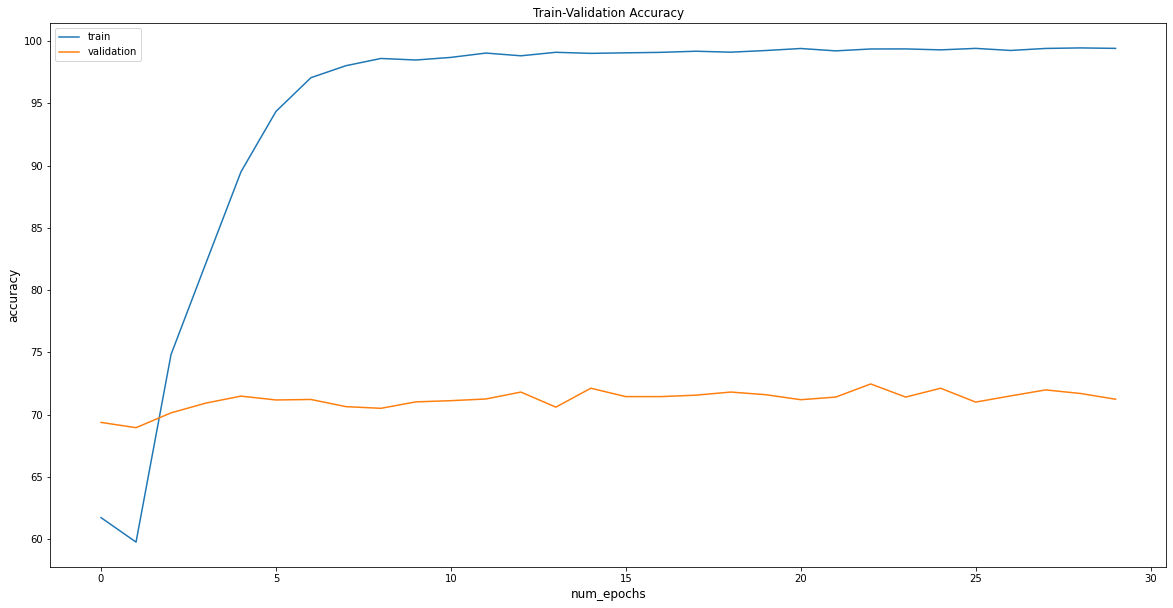

In [9]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

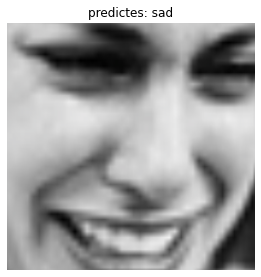

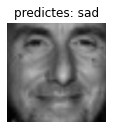

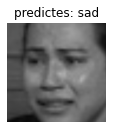

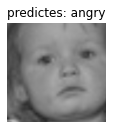

In [10]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()